Работа с sklearn, для понимания основных методов обучения, которые понадобятся мне для работы с фото

Подключение 

In [34]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from imblearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings('ignore')

Импорт данных

In [35]:

df1 = pd.read_csv('test.csv')
df2 = pd.read_csv('train.csv')
df3 = pd.read_csv('gender_submission.csv')
print(df2.head())


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


Теперь получим процент женщин и мужчин

In [36]:
women = df2.loc[df2.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

men = df2.loc[df2.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)


% of women who survived: 0.7420382165605095
% of men who survived: 0.18890814558058924


In [37]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


Посмотрим на взаимоотношения между различными величинами в датасете

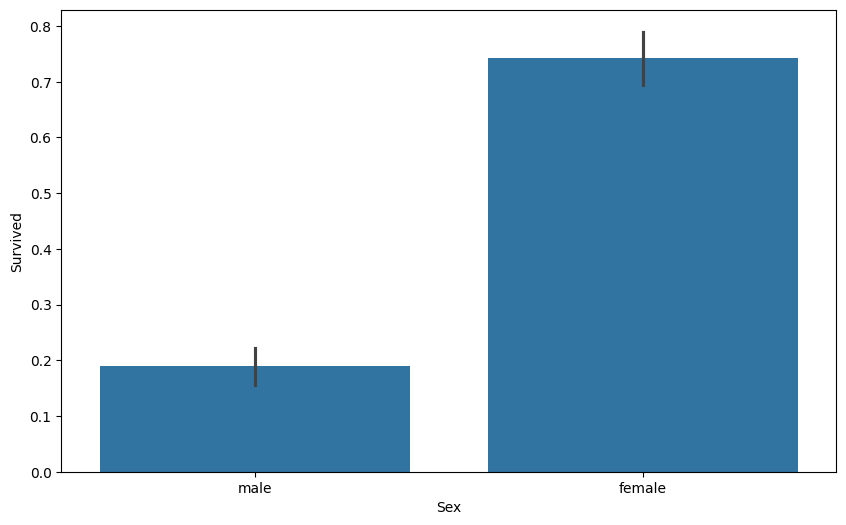

<Axes: title={'center': 'Survived and not survived people with their Fare and Age'}, xlabel='Survived', ylabel='Age'>

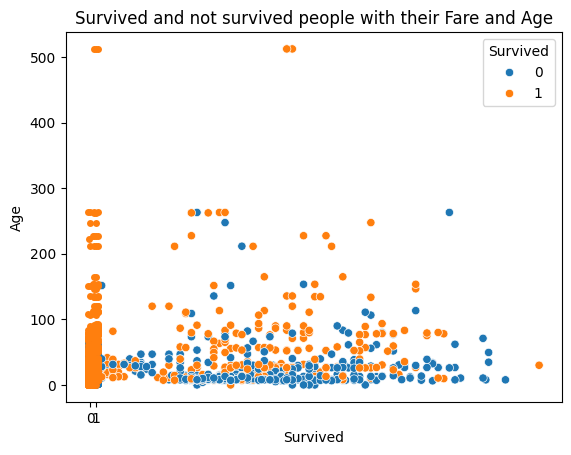

In [38]:


plt.figure(figsize=(10,6))


sns.barplot(x=df2['Sex'],
             y=df2['Survived'])
plt.show()


plt.title("Age of people who survived or did not survive")
sns.swarmplot(x=df2['Survived'], y=df2['Age'])
plt.title("People's Fair who survived or did not survive")
sns.swarmplot(x=df2['Survived'], y=df2['Fare'])


plt.title("Survived and not survived people with their Fare and Age")
sns.scatterplot(x=df2['Age'], y=df2['Fare'], hue=df2['Survived'])




Извлекаем целевую переменную для дальнейшей работы с датасетом:

In [39]:
y=df2['Survived'].values
y.shape

(891,)

Собираем вместе тренировочную и тестовую дату

In [40]:

# первым столбец 
df2=df2.drop(['Survived'], axis=1)
# сращиtest_dataваем таблицы
concated_data=pd.concat([df2,df1],ignore_index=True)
print(concated_data)



      PassengerId  Pclass                                               Name  \
0               1       3                            Braund, Mr. Owen Harris   
1               2       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2               3       3                             Heikkinen, Miss. Laina   
3               4       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4               5       3                           Allen, Mr. William Henry   
...           ...     ...                                                ...   
1304         1305       3                                 Spector, Mr. Woolf   
1305         1306       1                       Oliva y Ocana, Dona. Fermina   
1306         1307       3                       Saether, Mr. Simon Sivertsen   
1307         1308       3                                Ware, Mr. Frederick   
1308         1309       3                           Peter, Master. Michael J   

         Sex   Age  SibSp  Parch       

Далее для облегчения предсказания выживания чел-ка, необходимо понять, ехал он в одиночку или вместе с кем-то

In [41]:
concated_data['Relatives'] = concated_data['SibSp'] + concated_data['Parch']
concated_data.loc[concated_data['Relatives'] > 0, 'Alone'] = 0
concated_data.loc[concated_data['Relatives'] == 0, 'Alone'] = 1
print(concated_data.head())

   PassengerId  Pclass                                               Name  \
0            1       3                            Braund, Mr. Owen Harris   
1            2       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2            3       3                             Heikkinen, Miss. Laina   
3            4       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4            5       3                           Allen, Mr. William Henry   

      Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked  \
0    male  22.0      1      0         A/5 21171   7.2500   NaN        S   
1  female  38.0      1      0          PC 17599  71.2833   C85        C   
2  female  26.0      0      0  STON/O2. 3101282   7.9250   NaN        S   
3  female  35.0      1      0            113803  53.1000  C123        S   
4    male  35.0      0      0            373450   8.0500   NaN        S   

   Relatives  Alone  
0          1    0.0  
1          1    0.0  
2          0    1.0 

Далее датасет надо очистить от пустых полей

In [42]:
for col in concated_data.columns:
    print('{} column missing values: {}'.format(col, concated_data[col].isnull().sum()))

PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 263
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 1014
Embarked column missing values: 2
Relatives column missing values: 0
Alone column missing values: 0


Выведем пустые поля внутри concated_data

In [43]:
concated_data[concated_data['Embarked'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives,Alone
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0,1.0
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0,1.0


Теперь перейдём к очистке пустых полей

In [44]:
concated_data['Embarked'] = concated_data['Embarked'].fillna('S')
print("row 61: ",concated_data.iloc[61,10])
print("row 829: ",concated_data.iloc[829,10])


row 61:  S
row 829:  S


После нам необходимо отобрать признаки на основе которых бы будем обучать модель, в данном случае имеет значение:
класс пассажира, пол, возраст, наличие детей/родителей на борту, стоимость проезда, класс билета и родственники

In [45]:
X=concated_data[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Relatives']].values
print(X[0:5,:])

[[3 'male' 22.0 1 0 7.25 'S' 1]
 [1 'female' 38.0 1 0 71.2833 'C' 1]
 [3 'female' 26.0 0 0 7.925 'S' 0]
 [1 'female' 35.0 1 0 53.1 'S' 1]
 [3 'male' 35.0 0 0 8.05 'S' 0]]


Далее мы убираем пустые значение с помощью SimpleImputer

`SimpleImputer` — это класс из библиотеки `scikit-learn`, который используется для обработки пропущенных значений в наборах данных. Пропущенные значения могут возникать по разным причинам, и их наличие может негативно сказаться на качестве модели машинного обучения. `SimpleImputer` позволяет заполнять (импутировать) эти пропуски различными способами.

### Основные функции `SimpleImputer`:

1. **Заполнение пропусков**: `SimpleImputer` может заполнять пропущенные значения с использованием различных стратегий, таких как:
   - `mean`: среднее значение по столбцу (для числовых данных).
   - `median`: медиана по столбцу.
   - `most_frequent`: наиболее часто встречающееся значение.
   - `constant`: заполнение фиксированным значением.

2. **Простота использования**: Класс имеет простой интерфейс, который позволяет легко интегрировать его в процесс предобработки данных.

3. **Поддержка различных типов данных**: `SimpleImputer` может работать как с числовыми, так и с категориальными данными.

### Пример использования:

```python
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# Пример данных с пропущенными значениями
data = pd.DataFrame({
    'A': [1, 2, np.nan, 4],
    'B': [np.nan, 'b', 'c', 'd'],
})

# Создание объекта SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Для числовых данных
data['A'] = imputer.fit_transform(data[['A']])

imputer_cat = SimpleImputer(strategy='most_frequent')  # Для категориальных данных
data['B'] = imputer_cat.fit_transform(data[['B']])

print(data)
```

В этом примере пропущенные значения в столбце `A` заполняются средним значением, а в столбце `B` — наиболее часто встречающимся значением.

### Когда использовать `SimpleImputer`:

- Когда в данных есть пропущенные значения, и необходимо их обработать перед обучением модели.
- Когда нужно быстро и просто заполнить пропуски без сложных методов.

Использование `SimpleImputer` помогает улучшить качество данных и, как следствие, качество модели машинного обучения.


In [46]:
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(missing_values=np.nan, strategy='mean')

imputer.fit(X[:,2].reshape(-1,1))
X[:,2]=(imputer.transform(X[:,2].reshape(-1,1))).reshape(-1,)

imputer.fit(X[:,5].reshape(-1,1))
X[:,5]=(imputer.transform(X[:,5].reshape(-1,1))).reshape(-1,)

print(X[:6])

[[3 'male' 22.0 1 0 7.25 'S' 1]
 [1 'female' 38.0 1 0 71.2833 'C' 1]
 [3 'female' 26.0 0 0 7.925 'S' 0]
 [1 'female' 35.0 1 0 53.1 'S' 1]
 [3 'male' 35.0 0 0 8.05 'S' 0]
 [3 'male' 29.881137667304014 0 0 8.4583 'Q' 0]]


Теперь закодируем категориальные данные, используе м 
onehotencoder

In [47]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder 
ct=ColumnTransformer(transformers=[('encoder',OneHotEncoder(),[6])],remainder='passthrough')
X=np.array(ct.fit_transform(X))

print(X[:6,:])

[[0.0 0.0 1.0 3 'male' 22.0 1 0 7.25 1]
 [1.0 0.0 0.0 1 'female' 38.0 1 0 71.2833 1]
 [0.0 0.0 1.0 3 'female' 26.0 0 0 7.925 0]
 [0.0 0.0 1.0 1 'female' 35.0 1 0 53.1 1]
 [0.0 0.0 1.0 3 'male' 35.0 0 0 8.05 0]
 [0.0 1.0 0.0 3 'male' 29.881137667304014 0 0 8.4583 0]]


In [48]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
X[:,4]=le.fit_transform(X[:,4])
print(X[:6,:])
print("")

[[0.0 0.0 1.0 3 1 22.0 1 0 7.25 1]
 [1.0 0.0 0.0 1 0 38.0 1 0 71.2833 1]
 [0.0 0.0 1.0 3 0 26.0 0 0 7.925 0]
 [0.0 0.0 1.0 1 0 35.0 1 0 53.1 1]
 [0.0 0.0 1.0 3 1 35.0 0 0 8.05 0]
 [0.0 1.0 0.0 3 1 29.881137667304014 0 0 8.4583 0]]



Возвращаемся к тренировочному и тестовому набору данных

In [49]:
xx=X[0:418]
X=X[:891]
print(X.shape,xx.shape)



(891, 10) (418, 10)


In [50]:

print(xx[:6])

[[0.0 0.0 1.0 3 1 22.0 1 0 7.25 1]
 [1.0 0.0 0.0 1 0 38.0 1 0 71.2833 1]
 [0.0 0.0 1.0 3 0 26.0 0 0 7.925 0]
 [0.0 0.0 1.0 1 0 35.0 1 0 53.1 1]
 [0.0 0.0 1.0 3 1 35.0 0 0 8.05 0]
 [0.0 1.0 0.0 3 1 29.881137667304014 0 0 8.4583 0]]


Далее делим данные на тренировочный и тестовый набор с помощью инструментов sklearn

In [51]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=1)
print(x_train[:6])
print(x_test[:6])
print(y_train[:6])
print(y_test[:6])
print(x_train.shape,x_test.shape, y_train.shape, y_test.shape)

[[0.0 0.0 1.0 1 1 42.0 1 0 52.0 1]
 [0.0 1.0 0.0 3 1 29.881137667304014 1 0 15.5 1]
 [1.0 0.0 0.0 1 1 49.0 1 0 89.1042 1]
 [1.0 0.0 0.0 1 0 19.0 1 0 91.0792 1]
 [0.0 0.0 1.0 1 1 19.0 1 0 53.1 1]
 [0.0 0.0 1.0 2 0 27.0 1 0 21.0 1]]
[[0.0 0.0 1.0 1 0 48.0 0 0 25.9292 0]
 [0.0 0.0 1.0 3 1 29.881137667304014 0 0 7.8958 0]
 [0.0 0.0 1.0 2 0 17.0 0 0 10.5 0]
 [0.0 1.0 0.0 3 0 29.881137667304014 0 0 8.1375 0]
 [0.0 0.0 1.0 2 0 7.0 0 2 26.25 2]
 [0.0 0.0 1.0 3 1 21.0 0 0 7.8542 0]]
[0 0 1 1 0 0]
[1 0 1 0 1 0]
(668, 10) (223, 10) (668,) (223,)


Масштабирование признаков

Масштабирование признаков (feature scaling) — это важный этап предобработки данных в машинном обучении, который помогает улучшить производительность и сходимость алгоритмов. Вот основные аспекты, касающиеся масштабирования признаков и его необходимости:

### Что такое масштабирование признаков?

Масштабирование признаков — это процесс изменения диапазона значений признаков (или переменных) в наборе данных. Это может включать в себя:

1. **Стандартизация**: Приведение данных к стандартному нормальному распределению (среднее 0 и стандартное отклонение 1). Это достигается путем вычитания среднего значения и деления на стандартное отклонение.
2. **Нормализация**: Приведение данных к диапазону [0, 1] или [-1, 1]. Это может быть полезно, когда данные имеют разные масштабы.

### Зачем нужно масштабирование признаков?

1. **Улучшение сходимости**: Многие алгоритмы машинного обучения, такие как градиентный спуск, быстрее сходятся, когда данные находятся в одном масштабе. Если признаки имеют разные диапазоны, это может привести к медленной сходимости или даже к проблемам с обучением.

2. **Сравнение признаков**: Если признаки имеют разные единицы измерения (например, возраст в годах и доход в долларах), их сравнение может быть затруднено. Масштабирование помогает привести все признаки к единому масштабу.

3. **Улучшение производительности моделей**: Некоторые алгоритмы, такие как K-ближайших соседей (KNN) и методы на основе расстояний (например, SVM), чувствительны к масштабу данных. Масштабирование может значительно улучшить их производительность.

4. **Избежание доминирования признаков**: Если один признак имеет значительно больший диапазон значений, он может доминировать над другими признаками в процессе обучения модели, что может привести к неправильным выводам.

### Пример использования

В приведенном вами фрагменте кода используется `StandardScaler` для стандартизации признаков в обучающей и тестовой выборках. Это позволяет привести данные к единому масштабу, что улучшает качество и скорость обучения модели.

In [54]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
x_train[:,3:]=sc.fit_transform(x_train[:,3:])
x_test[:,3:]=sc.transform(x_test[:,3:])
xx[:,3:]=sc.transform(xx[:,3:])
print(x_train[:6])
print(x_test[:6])

[[0.0 0.0 1.0 -1.5932633446827138 0.7318689663512502 0.9040165883511854
  0.4923686893906595 -0.4868644955601493 0.4442643833982735
  0.07784755093219699]
 [0.0 1.0 0.0 0.8173819877024568 0.7318689663512502 -0.011651581396075283
  0.4923686893906595 -0.4868644955601493 -0.34951363834932564
  0.07784755093219699]
 [1.0 0.0 0.0 -1.5932633446827138 0.7318689663512502 1.4329174878141562
  0.4923686893906595 -0.4868644955601493 1.2511821498236784
  0.07784755093219699]
 [1.0 0.0 0.0 -1.5932633446827138 -1.3663648084240076 -0.8338006527414333
  0.4923686893906595 -0.4868644955601493 1.294133152370295
  0.07784755093219699]
 [0.0 0.0 1.0 -1.5932633446827138 0.7318689663512502 -0.8338006527414333
  0.4923686893906595 -0.4868644955601493 0.46818646076600945
  0.07784755093219699]
 [0.0 0.0 1.0 -0.3879406784901286 -1.3663648084240076 -0.2293424819266094
  0.4923686893906595 -0.4868644955601493 -0.22990325151064628
  0.07784755093219699]]
[[0.0 0.0 1.0 -1.5932633446827138 -1.3663648084240076 1.35

Метод главных компонент (PCA, Principal Component Analysis) — это статистический метод, используемый для снижения размерности данных. Он позволяет преобразовать набор наблюдений с большим количеством переменных в набор с меньшим количеством переменных, сохраняя при этом как можно больше информации о данных. Вот основные аспекты PCA и его применения:
Что такое PCA?

    Снижение размерности: PCA позволяет уменьшить количество переменных (или признаков) в наборе данных, что может быть полезно, когда у вас есть много признаков, и вы хотите упростить анализ или визуализацию.

    Главные компоненты: PCA находит новые оси (главные компоненты), которые представляют собой линейные комбинации исходных переменных. Эти оси выбираются таким образом, чтобы максимизировать дисперсию данных. Первая главная компонента объясняет наибольшую часть вариации в данных, вторая — наибольшую часть оставшейся вариации и так далее.

    Ортогональность: Главные компоненты ортогональны (независимы) друг от друга, что позволяет избежать многоколлинеарности (взаимосвязи между переменными) в данных.

Зачем нужен PCA?

    Упрощение модели: Уменьшая количество признаков, PCA может помочь упростить модели машинного обучения, что может привести к более быстрой обработке и меньшему риску переобучения.

    Визуализация данных: Снижение размерности позволяет визуализировать многомерные данные в 2D или 3D, что может помочь в понимании структуры данных и выявлении паттернов.

    Устранение шумов: PCA может помочь в фильтрации шумов в данных, так как он фокусируется на направлениях с наибольшей вариацией, игнорируя менее значимые компоненты.

    Подготовка данных: PCA часто используется как предварительный шаг перед применением других методов машинного обучения, чтобы улучшить качество данных и ускорить обучение моделей.

Применение PCA

PCA находит применение в различных областях, таких как:

    Обработка изображений (уменьшение размерности изображений)
    Геномика (анализ данных о генах)
    Финансовый анализ (снижение размерности финансовых показателей)
    Обработка текстов (уменьшение размерности векторных представлений текстов)

В целом, PCA является мощным инструментом для анализа и обработки данных, особенно когда работа идет с высокоразмерными наборами данных.

In [55]:
from sklearn.decomposition import PCA
pca=PCA(n_components=6)
x_train=pca.fit_transform(x_train)
x_test=pca.transform(x_test)
xx = pca.transform(xx)
print(x_train[:6])
print(x_test[:6])
print(x_train.shape,x_test.shape)

[[-9.87433935e-02 -1.47848304e+00  1.24807222e+00  2.20163617e-02
  -5.53133208e-01 -7.71794440e-01]
 [-2.59759674e-01  9.19049613e-01  6.39943307e-01  4.74414802e-02
  -5.73371257e-01  7.12931539e-01]
 [-1.13469954e-03 -2.31415973e+00  1.34779207e+00  2.53281461e-02
  -6.11860745e-01  3.24975462e-01]
 [ 9.14303613e-01 -1.74302054e+00 -1.16399833e+00 -1.29025252e+00
  -1.02408098e+00 -5.63496050e-02]
 [ 2.25982773e-01 -7.68141776e-01  7.41112245e-01 -1.41500876e+00
  -4.92632387e-01 -1.05387261e+00]
 [ 3.76276143e-01 -1.73586361e-01 -1.06214763e+00  1.58536288e-01
  -9.84252051e-01 -5.75361350e-01]]
[[-0.71728926 -1.88214947 -0.91378748  1.04118275 -0.46182889 -0.98014956]
 [-1.16020604  0.8634724   0.35248347 -0.00966819  0.17172668  0.1843944 ]
 [-0.42499072  0.08496823 -1.70179433 -0.51037341 -0.34189054 -0.77178952]
 [-0.69364175  0.47582489 -1.62494563  0.53615002 -0.44487431  0.66478169]
 [ 1.83534674  0.402119   -1.73608238 -0.62572805  1.53817686 -0.92700917]
 [-1.03734782  1.1

K-Fold Cross Validation (K-кратная перекрестная проверка) — это метод оценки производительности модели машинного обучения, который помогает избежать переобучения и обеспечивает более надежную оценку качества модели. Давайте разберем, что это такое и зачем он нужен.

### Что такое K-Fold Cross Validation?

1. **Разделение данных**: В K-Fold Cross Validation весь набор данных делится на K равных (или почти равных) частей, называемых "фолдами". Например, если K=5, данные делятся на 5 частей.

2. **Обучение и тестирование**: Процесс обучения и тестирования модели выполняется K раз. На каждой итерации:
   - Один из фолдов используется в качестве тестового набора (валидационного), а остальные K-1 фолдов используются для обучения модели.
   - Модель обучается на K-1 фолдах и затем тестируется на оставшемся фолде.

3. **Сбор результатов**: После завершения всех K итераций, результаты (например, точность, F1-меру и т.д.) собираются и усредняются, чтобы получить общую оценку производительности модели.

### Зачем нужен K-Fold Cross Validation?

1. **Устойчивость к переобучению**: K-Fold Cross Validation помогает выявить, насколько хорошо модель обобщает данные. Если модель показывает высокую производительность только на обучающих данных, но плохо на тестовых, это может указывать на переобучение. Перекрестная проверка позволяет оценить модель на разных поднаборах данных.

2. **Более надежная оценка**: Используя K-Fold, мы получаем несколько оценок производительности модели, что позволяет получить более надежную и стабильную оценку, чем при использовании одного разделения на обучающую и тестовую выборки.

3. **Эффективное использование данных**: K-Fold Cross Validation позволяет использовать все доступные данные для обучения и тестирования. Каждый экземпляр данных будет использован как в обучающей, так и в тестовой выборке, что особенно полезно при ограниченном объеме данных.

4. **Выбор гиперпараметров**: K-Fold Cross Validation часто используется в процессе настройки гиперпараметров модели. Это позволяет оценить, как изменения в гиперпараметрах влияют на производительность модели.

### Применение K-Fold Cross Validation

K-Fold Cross Validation широко используется в различных задачах машинного обучения, включая классификацию, регрессию и другие области, где необходимо оценить качество модели. Это один из стандартных методов, который помогает исследователям и практикам уверенно оценивать и сравнивать модели.

In [57]:
def K_Fold_CV(model):
    pipeline = make_pipeline(model)
    scores = cross_val_score(pipeline, X=x_train, y=y_train, cv=10, n_jobs=1)
    print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))
    return (np.mean(scores))

Hyperparameter tuning (настройка гиперпараметров) — это процесс оптимизации гиперпараметров модели машинного обучения для достижения наилучших результатов. Гиперпараметры — это параметры, которые не обучаются непосредственно в процессе обучения модели, а устанавливаются заранее. Они могут включать в себя такие параметры, как скорость обучения, количество слоев в нейронной сети, размер мини-батча и другие.

Зачем нужно гиперпараметрическое тюнингование:

1. **Улучшение производительности модели**: Правильная настройка гиперпараметров может значительно повысить точность и обобщающую способность модели.

2. **Избежание переобучения**: Некоторые гиперпараметры могут помочь предотвратить переобучение, что позволяет модели лучше работать на новых, невидимых данных.

3. **Оптимизация времени обучения**: Настройка гиперпараметров может помочь сократить время, необходимое для обучения модели, путем выбора более эффективных значений.

4. **Адаптация к данным**: Разные наборы данных могут требовать различных настроек гиперпараметров для достижения наилучших результатов.

Существует несколько методов гиперпараметрического тюнингования, включая:

- **Случайный поиск** (Random Search)
- **Сеточный поиск** (Grid Search)
- **Байесовская оптимизация** (Bayesian Optimization)
- **Методы на основе эволюции** (Evolutionary Methods)

Каждый из этих методов имеет свои преимущества и недостатки, и выбор подходящего метода зависит от конкретной задачи и доступных ресурсов.

In [58]:
# Used to find the best hyperparameters for a given model
def best_param(model,param_grid):
    gs=GridSearchCV(model,param_grid,cv=10)
    gs.fit(x_train,y_train)
    print("best params: ",gs.best_params_)

Confusion matrix (матрица путаницы) — это инструмент, используемый для оценки качества работы классификационной модели в машинном обучении. Она позволяет визуализировать, как хорошо модель классифицирует данные, сравнивая предсказанные классы с истинными классами.

### Структура матрицы путаницы

Матрица путаницы обычно имеет вид 2x2 для бинарной классификации и может быть расширена для многоклассовой классификации. В случае бинарной классификации она состоит из четырех элементов:

- **True Positive (TP)**: количество положительных примеров, правильно классифицированных как положительные.
- **True Negative (TN)**: количество отрицательных примеров, правильно классифицированных как отрицательные.
- **False Positive (FP)**: количество отрицательных примеров, ошибочно классифицированных как положительные (также называется "ложные срабатывания").
- **False Negative (FN)**: количество положительных примеров, ошибочно классифицированных как отрицательные (также называется "ложные отрицания").

### Зачем нужна матрица путаницы

1. **Оценка производительности модели**: Матрица путаницы позволяет получить более полное представление о том, как модель работает, чем просто использование одной метрики, такой как точность.

2. **Выявление проблем**: Она помогает выявить, какие классы модель путает, что может быть полезно для дальнейшего улучшения модели.

3. **Расчет других метрик**: На основе значений в матрице путаницы можно вычислить различные метрики, такие как:
   - **Точность (Accuracy)**: (TP + TN) / (TP + TN + FP + FN)
   - **Полнота (Recall)**: TP / (TP + FN)
   - **Точность (Precision)**: TP / (TP + FP)
   - **F1-мера**: 2 * (Precision * Recall) / (Precision + Recall)

4. **Анализ многоклассовых задач**: Для многоклассовой классификации матрица путаницы может быть расширена, что позволяет анализировать производительность модели по каждому классу.

В целом, матрица путаницы является важным инструментом для анализа и улучшения моделей машинного обучения, особенно в задачах классификации.

In [87]:
from sklearn.metrics import mean_squared_error
best_Acc={
    
    }
def Confusion_Matrix(y_pred,name):
    cm=confusion_matrix(y_test,y_pred)
    print(cm)
    print("")
    print("Sum of Wrong predictions",cm[0,1]+cm[1,0])
    print("Accuracy of the model: ",accuracy_score(y_test,y_pred))
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)
    best_Acc[name]=accuracy_score(y_test,y_pred)

Проверка переобучения (checking for overfitting) — это процесс оценки модели машинного обучения, чтобы определить, не слишком ли она адаптировалась к обучающим данным, что может привести к плохой обобщающей способности на новых, невидимых данных.

### Что такое переобучение?

Переобучение происходит, когда модель слишком сложна и начинает запоминать шум и случайные колебания в обучающих данных, вместо того чтобы выявлять общие закономерности. В результате такая модель может показывать высокую точность на обучающем наборе данных, но низкую точность на тестовом наборе данных.

### Зачем необходимо проверять переобучение?

1. **Обобщающая способность**: Основная цель модели машинного обучения — хорошо работать на новых данных. Проверка на переобучение помогает убедиться, что модель не просто запомнила обучающие данные, а действительно научилась выявлять закономерности.

2. **Оптимизация модели**: Понимание того, что модель переобучена, может помочь в выборе более простых моделей или в применении методов регуляризации, таких как L1 или L2 регуляризация, которые помогают предотвратить переобучение.

3. **Выбор гиперпараметров**: Проверка на переобучение может помочь в настройке гиперпараметров модели, таких как количество слоев в нейронной сети или скорость обучения, чтобы достичь лучшего баланса между обучением и обобщением.

4. **Улучшение качества предсказаний**: Понимание и устранение переобучения может привести к более точным и надежным предсказаниям, что особенно важно в критически важных приложениях, таких как медицина или финансы.

### Методы проверки переобучения

1. **Разделение данных**: Использование обучающего, валидационного и тестового наборов данных. Модель обучается на обучающем наборе, а затем проверяется на валидационном и тестовом наборах.

2. **Кросс-валидация**: Разделение данных на несколько подмножеств и многократное обучение и тестирование модели на этих подмножествах для получения более надежной оценки производительности.

3. **Графики обучения**: Построение графиков, показывающих изменение точности и потерь на обучающем и валидационном наборах данных в процессе обучения. Если точность на обучающем наборе продолжает расти, а на валидационном — начинает снижаться, это может быть признаком переобучения.

4. **Регуляризация**: Применение методов регуляризации, чтобы уменьшить сложность модели и предотвратить переобучение.

Проверка на переобучение является важным этапом в процессе разработки моделей машинного обучения, так как она помогает обеспечить их надежность и эффективность в реальных условиях.

In [60]:
def check_Overfitting(yhat_test,model):
    yhat_train=model.predict(x_train)
    return accuracy_score(y_train,yhat_train),accuracy_score(y_test,yhat_test)

Далее разберём основные методы обучения модели, которые могут пригодиться мне далее, для работы с фото

**Бустинг** — это метод ансамблевого обучения в машинном обучении, который объединяет несколько слабых моделей (обычно классификаторов) для создания одной сильной модели. Основная идея бустинга заключается в том, чтобы последовательно обучать модели, при этом каждая последующая модель фокусируется на ошибках предыдущих. Это позволяет улучшить общую производительность модели и уменьшить ошибки.

### Основные виды бустинга

1. **AdaBoost (Adaptive Boosting)**:
   - Один из первых и наиболее известных алгоритмов бустинга.
   - Работает путем присвоения весов ошибочным классификациям, чтобы последующие модели могли лучше справляться с ними.
   - Обычно используется с простыми моделями, такими как решающие деревья с малой глубиной (стебли).

2. **Gradient Boosting**:
   - Строит модели последовательно, каждая из которых обучается на градиенте ошибки предыдущей модели.
   - Позволяет оптимизировать произвольную дифференцируемую функцию потерь.
   - Широко используется в задачах регрессии и классификации.

3. **XGBoost (Extreme Gradient Boosting)**:
   - Расширение алгоритма градиентного бустинга, которое оптимизировано для скорости и производительности.
   - Включает регуляризацию, что помогает предотвратить переобучение.
   - Часто используется в соревнованиях по машинному обучению из-за своей высокой эффективности.

4. **LightGBM**:
   - Еще одно расширение градиентного бустинга, разработанное Microsoft.
   - Использует метод "гистограммного" бустинга, что позволяет значительно ускорить обучение и уменьшить использование памяти.
   - Подходит для работы с большими наборами данных.

5. **CatBoost**:
   - Алгоритм бустинга, разработанный Яндексом, который хорошо работает с категориальными признаками.
   - Автоматически обрабатывает категориальные данные, что упрощает предобработку.
   - Обеспечивает высокую производительность и устойчивость к переобучению.

### Применение бустинга

Бустинг используется в различных задачах машинного обучения, включая:

- Классификация (например, распознавание образов, анализ текста)
- Регрессия (например, предсказание цен, временные ряды)
- Ранжирование (например, в системах рекомендаций)

Бустинг является мощным инструментом, который может значительно улучшить качество предсказаний, особенно в сложных задачах. Однако важно следить за переобучением, так как сложные модели могут легко подстраиваться под шум в данных.

In [88]:
from sklearn.ensemble import GradientBoostingClassifier
classifier = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01, max_depth=15, random_state=42)
best_K_FCV={
    "GradientBoostingClassifier":K_Fold_CV(classifier)
}
classifier.fit(x_train,y_train)

Cross Validation accuracy: 0.798 +/- 0.068


GradientBoostingClassifier(learning_rate=0.01, max_depth=15, n_estimators=1000,
                           random_state=42)

In [ ]:
y_pred=classifier.predict(x_test)
Overfitting={
    "train_Log,test_log":check_Overfitting(y_pred,classifier)
}
y_pred_TD_LogR=classifier.predict(xx)

In [90]:
print((np.concatenate((y_pred.reshape(len(y_pred),1),y_test.reshape(len(y_test),1)),1))[:20])

[[1 1]
 [0 0]
 [1 1]
 [1 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 0]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [0 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 1]]


In [91]:
Confusion_Matrix(y_pred,"Logistic Regression")

[[104  24]
 [ 35  60]]

Sum of Wrong predictions 59
Accuracy of the model:  0.7354260089686099
Mean Squared Error: 0.2645739910313901


Кластеризация

In [108]:
from sklearn.cluster import KMeans
classifier = KMeans(n_clusters=600, random_state=42)
best_K_FCV={
    "KMeans":K_Fold_CV(classifier)
}
classifier.fit(x_train,y_train)

y_pred=classifier.predict(x_test)
Overfitting={
    "train_Log,test_log":check_Overfitting(y_pred,classifier)
}
y_pred_TD_LogR=classifier.predict(xx)
print((np.concatenate((y_pred.reshape(len(y_pred),1),y_test.reshape(len(y_test),1)),1))[:20])
Confusion_Matrix(y_pred,"Logistic Regression")

Cross Validation accuracy: -24.932 +/- 9.818
[[210   1]
 [428   0]
 [326   1]
 [546   0]
 [158   1]
 [588   0]
 [161   0]
 [353   1]
 [242   0]
 [355   1]
 [189   0]
 [  6   1]
 [430   0]
 [385   1]
 [593   1]
 [469   1]
 [145   0]
 [357   0]
 [361   0]
 [ 32   1]]
[[0 0 0 ... 1 0 0]
 [1 0 1 ... 0 1 3]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Sum of Wrong predictions 1
Accuracy of the model:  0.0
Mean Squared Error: 118623.78923766816
